In [7]:
import pandas as pd
import numpy as np
2
df = pd.read_csv('/-/Tugas 1 Single Layer Perceptron/data - Sheet1.csv')
df.head()

,No,X0,X1,X2,X3,X4,TARGET
0,1,1,5.1,3.5,1.4,0.2,0
1,2,1,4.9,3.0,1.4,0.2,0
2,3,1,4.7,3.2,1.3,0.2,0
3,4,1,4.6,3.1,1.5,0.2,0
4,5,1,5.0,3.6,1.4,0.2,0


In [8]:
df.shape

(100, 7)

In [9]:
df = df.drop('No', axis=1) # Kita drop colom No, agar hanya tersisa fitur-fitur dan target.

In [10]:
# Cek jika ada missing values
print(df.shape)
print(df.info())
print(df.isna().sum())

(100, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      100 non-null    int64  
 1   X1      100 non-null    float64
 2   X2      100 non-null    float64
 3   X3      100 non-null    float64
 4   X4      100 non-null    float64
 5   TARGET  100 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 4.8 KB
None
X0        0
X1        0
X2        0
X3        0
X4        0
TARGET    0
dtype: int64


In [11]:
# Split data menjadi training dan testing (80:20)

X = df.drop(columns=["TARGET"]).values
y = df["TARGET"].values

X_train, y_train = X[:80], y[:80]
X_test, y_test = X[80:], y[80:]

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80, 5), (80,), (20, 5), (20,))

### Dot product

In [14]:
def dot_product_z(X_train_row, vektor_bobot):
  return float(np.dot(X_train_row, vektor_bobot))

### Sigmoid

In [18]:
def sigmoid_gz(z):
  return 1 / (1 + np.exp(-z))

### error

In [20]:
y_train[0]

np.int64(0)

In [21]:
def error_sq(sigmoid_gz, target):
  return (sigmoid_gz - target)**2

### delta

In [23]:
def delta(sigmoid_gz, target, fitur):
  return 2*(sigmoid_gz-target)*(1-sigmoid_gz)*sigmoid_gz*fitur

### bobot baru

In [32]:
def new_weights(vektor_bobot_sebelum, vektor_delta_sebelum, learning_rate):
    v_bobot = np.array(vektor_bobot_sebelum, dtype=float)
    v_delta = np.array(vektor_delta_sebelum, dtype=float)
    return (v_bobot - learning_rate * v_delta).tolist()

In [27]:
def log_bobot_append(logs_bobot, epoch, data_index, vektor_bobot, z, gz, pred, error2):
  row = {
        "epoch": epoch,
        "data_index": data_index,
        "bias": vektor_bobot[0],
        "teta1": vektor_bobot[1],
        "teta2": vektor_bobot[2],
        "teta3": vektor_bobot[3],
        "teta4": vektor_bobot[4],
        "z": z,
        "gz": gz,
        "pred": pred,
        "error2": error,
    }
  logs_bobot.append(row)

In [28]:
def log_delta_append(logs_delta, epoch, data_index, delta_values):
    row = {
        "epoch": epoch,
        "data_index": data_index,
        "dbias": delta_values[0],
        "dteta1": delta_values[1],
        "dteta2": delta_values[2],
        "dteta3": delta_values[3],
        "dteta4": delta_values[4]
    }
    logs_delta.append(row)

In [29]:
def log_truth_diff_append(logs_diff, epoch, data_index, prediction, true_label):
    row = {
        "epoch": epoch,
        "data_index": data_index,
        "nilai": 1 if prediction == true_label else 0
    }
    logs_diff.append(row)

In [42]:
def logs_acc_loss_append(logs_acc_loss, epoch, split, avg_acc, avg_loss):
    row = {
        "epoch": epoch,
        "split": split,
        "avg acc": avg_acc,
        "avg loss" : avg_loss
    }
    logs_acc_loss.append(row)

### Training looping

In [113]:
learning_rate = 0.1
epoch = 5

logs_bobot = []
logs_delta = []
logs_prediction_truth_difference = []
logs_acc_loss = []

n_tr = len(X_train)
n_te = len(X_test)

# Track the current weights selama training
current_weights = [0.5, 0.5, 0.5, 0.5, 0.5]  # Initial weights

for i in range(epoch):
    # --------------------- Training ---------------------
    for j in range(n_tr):
        # Use current weights for forward pass
        dot_product_result = dot_product_z(X_train[j], current_weights)
        sigmoid_result = sigmoid_gz(dot_product_result)
        prediction = 1 if sigmoid_result >= 0.5 else 0
        error = error_sq(sigmoid_result, y_train[j])

        # Log results with current weights
        log_bobot_append(logs_bobot, i + 1, j + 1, current_weights,
                       dot_product_result, sigmoid_result, prediction, error)

        # Calculate delta
        delta_weights_values = delta(sigmoid_result, y_train[j], X_train[j])
        log_delta_append(logs_delta, i + 1, j + 1, delta_weights_values)

        # Log prediction vs truth
        true_label = y_train[j]
        log_truth_diff_append(logs_prediction_truth_difference, i + 1, j + 1,
                            prediction, true_label)

        # Update weights for next iteration
        current_weights = new_weights(current_weights, delta_weights_values, learning_rate)

    # --- Training metrics for epoch i ---
    # Calculate where this epoch's training data starts and ends in the logs
    epoch_start_idx = i * (n_tr + n_te)
    train_start_idx = epoch_start_idx
    train_end_idx = train_start_idx + n_tr

    # Extract training predictions and errors for this epoch
    train_preds = []
    train_errors = []
    for idx in range(train_start_idx, train_end_idx):
        if idx < len(logs_prediction_truth_difference):
            train_preds.append(logs_prediction_truth_difference[idx]["nilai"])
        if idx < len(logs_bobot):
            train_errors.append(logs_bobot[idx]["error2"])

    avg_acc_tr = float(np.mean(train_preds)) if train_preds else 0.0
    avg_loss_tr = float(np.mean(train_errors)) if train_errors else 0.0

    logs_acc_loss_append(logs_acc_loss, i + 1, 'training', avg_acc_tr, avg_loss_tr)

    # --------------------- Testing ---------------------
    # Use the weights after all training updates for testing
    for k in range(n_te):
        dot_product_result = dot_product_z(X_test[k], current_weights)
        sigmoid_result = sigmoid_gz(dot_product_result)
        prediction = 1 if sigmoid_result >= 0.5 else 0
        error = error_sq(sigmoid_result, y_test[k])

        # Log results - using the final weights from training
        log_bobot_append(logs_bobot, i + 1, n_tr + k + 1, current_weights,
                       dot_product_result, sigmoid_result, prediction, error)

        # No weight updates during testing
        log_delta_append(logs_delta, i + 1, n_tr + k + 1, [0, 0, 0, 0, 0])

        # Log prediction vs truth
        true_label = y_test[k]
        log_truth_diff_append(logs_prediction_truth_difference, i + 1, n_tr + k + 1,
                            prediction, true_label)

    # --- Validation metrics for epoch i ---
    val_start_idx = train_end_idx
    val_end_idx = val_start_idx + n_te

    # Extract validation predictions and errors for this epoch
    val_preds = []
    val_errors = []
    for idx in range(val_start_idx, val_end_idx):
        if idx < len(logs_prediction_truth_difference):
            val_preds.append(logs_prediction_truth_difference[idx]["nilai"])
        if idx < len(logs_bobot):
            val_errors.append(logs_bobot[idx]["error2"])

    avg_acc_val = float(np.mean(val_preds)) if val_preds else 0.0
    avg_loss_val = float(np.mean(val_errors)) if val_errors else 0.0

    logs_acc_loss_append(logs_acc_loss, i + 1, 'validation', avg_acc_val, avg_loss_val)

In [110]:
pred_values = [row["error2"] for row in logs_bobot]
avg = np.mean(pred_values)
avg

np.float64(0.21238388211613846)

In [114]:
pd.DataFrame(logs_acc_loss)

,epoch,split,avg acc,avg loss
0,1,training,0.5250,0.449314
1,1,validation,0.5000,0.326215
2,2,training,0.9500,0.034979
3,2,validation,0.5000,0.244152
4,3,training,0.9750,0.023202
5,3,validation,0.5000,0.172498
6,4,training,0.9750,0.016483
7,4,validation,0.8500,0.116599
8,5,training,0.9875,0.012349
9,5,validation,1.0000,0.078042


In [115]:
pd.DataFrame(logs_prediction_truth_difference)

,epoch,data_index,nilai
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,0
...,...,...,...
495,5,96,1
496,5,97,1
497,5,98,1
498,5,99,1


In [116]:
pd.DataFrame(logs_bobot)

,epoch,data_index,bias,teta1,teta2,teta3,teta4,z,gz,pred,error2
0,1,1,0.500000,0.500000,0.500000,0.500000,0.500000,5.600000,0.996316,1,0.992645
1,1,2,0.499269,0.496270,0.497440,0.498976,0.499854,5.221847,0.994632,1,0.989292
2,1,3,0.498206,0.491065,0.494253,0.497489,0.499641,5.134487,0.994144,1,0.988323
3,1,4,0.497049,0.485625,0.490550,0.495984,0.499410,5.095487,0.993913,1,0.987863
4,1,5,0.495846,0.480093,0.486821,0.494180,0.499169,5.440555,0.995682,1,0.991382
...,...,...,...,...,...,...,...,...,...,...,...
495,5,96,0.301642,-0.238123,-0.445912,1.123327,0.802592,3.287689,0.964004,1,0.001296
496,5,97,0.301642,-0.238123,-0.445912,1.123327,0.802592,3.412539,0.968094,1,0.001018
497,5,98,0.301642,-0.238123,-0.445912,1.123327,0.802592,3.405810,0.967886,1,0.001031
498,5,99,0.301642,-0.238123,-0.445912,1.123327,0.802592,2.225267,0.902496,1,0.009507


In [117]:
pd.DataFrame(logs_delta)

,epoch,data_index,dbias,dteta1,dteta2,dteta3,dteta4
0,1,1,0.007314,0.037303,0.025600,0.010240,0.001463
1,1,2,0.010622,0.052047,0.031865,0.014870,0.002124
2,1,3,0.011574,0.054400,0.037038,0.015047,0.002315
3,1,4,0.012026,0.055321,0.037282,0.018040,0.002405
4,1,5,0.008562,0.042811,0.030824,0.011987,0.001712
...,...,...,...,...,...,...,...
495,5,96,0.000000,0.000000,0.000000,0.000000,0.000000
496,5,97,0.000000,0.000000,0.000000,0.000000,0.000000
497,5,98,0.000000,0.000000,0.000000,0.000000,0.000000
498,5,99,0.000000,0.000000,0.000000,0.000000,0.000000


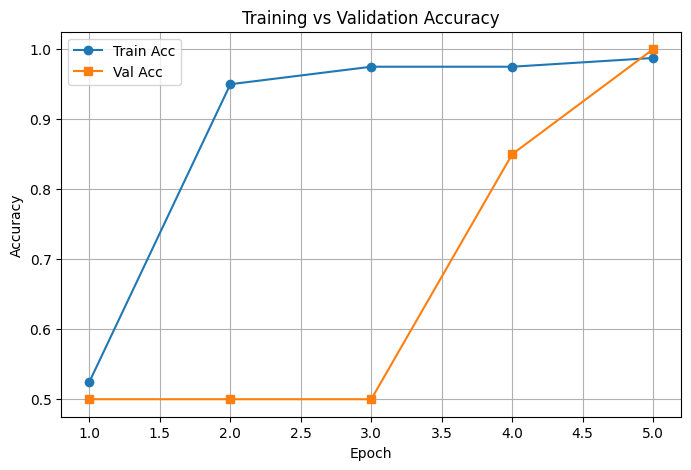

In [119]:
import matplotlib.pyplot as plt

# ubah jadi DataFrame
df_logs = pd.DataFrame(logs_acc_loss)

# buat figure
plt.figure(figsize=(8,5))

# plot accuracy
plt.plot(df_logs[df_logs["split"]=="training"]["epoch"],
         df_logs[df_logs["split"]=="training"]["avg acc"],
         marker="o", label="Train Acc")
plt.plot(df_logs[df_logs["split"]=="validation"]["epoch"],
         df_logs[df_logs["split"]=="validation"]["avg acc"],
         marker="s", label="Val Acc")

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


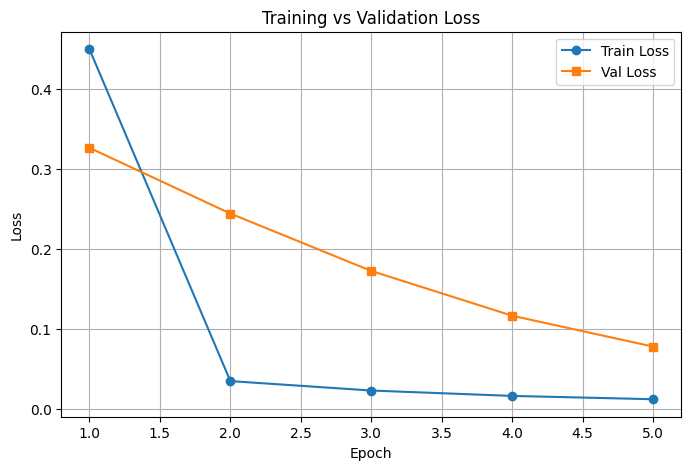

In [120]:
plt.figure(figsize=(8,5))

plt.plot(df_logs[df_logs["split"]=="training"]["epoch"],
         df_logs[df_logs["split"]=="training"]["avg loss"],
         marker="o", label="Train Loss")
plt.plot(df_logs[df_logs["split"]=="validation"]["epoch"],
         df_logs[df_logs["split"]=="validation"]["avg loss"],
         marker="s", label="Val Loss")

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
